In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, math, re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In C:\Users\Kyle\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Kyle\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Kyle\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Kyle\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Kyle\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

<h3>Starting Notes / Jumping Off Points</h3>
<ul>
    <li>Create A Regression Model for Scores</li>
    <ul>
    <li>From a single score, we can compute all the other metrics the market provides (Spread, Moneyline and Totals)</li>
    <li>We will use our computed metrics and compared them amongst the sportsbook's own lines and come up with a decision point of which side to take based on if our number is higher or lower than the market's</li>
    <li>From these picks that come from our calculated model, we can use these to compare to the market rates and generate winning percentages, wins and dollars won for all games.</li>
    <li>We can evaluate how our model performs in a whole host of market conditions which are already part of our data. We can evaluate our performance based on books, on average lines/odds, on best and worst lines/odds, and on opening lines/odds.</li>
    <li>The Data Can be Further Filtered by Team, Seasons, Months, Playoffs.</li>
    </ul>
    <li>Questions To Consider:</li>
        <ul>
            <li>Which Teams Were Most Off-Market? (we should see this in highest and lowest cover %)</li>
            <li>How Do Our Picks Fair Divourced from Time? (this can be done by picking out our picks from time and evaluating our cumulative winnings)</li>
            <li>Related to The Question Above: On Average, How Much Money Does a Random Walk Off All Our Picks Leave Us With at the End of the Season?</li>
            <li>Which Teams Did My Model Most Differ From the Market? (model average spread vs. market average spread)</li>
            <li>How Did My Model Meaningfully Change With Added Variables? (examine degree and distribution of errors)</li>
        </ul>
</ul>

<h1>Goals:</h1>
    <ol>
    <li>Create a Regression Model For Scores</li>
    <ul>
        <li>Create a Model for Scores Based On Known Data</li>
        <li>Once we have a working model with perfect information, Create a Model Based On Imperfect Data (rolling aggregation of results of past games)</li>
        <li>Compared Best Model against the baseline of 50%</li>
    </ul>
    <li>Create Visualizations Slicing The Data That Answer Key Questions and Provide Decision Points</li>
    <ul>
        <li>This should be a visualization sandbox where all visualizations I can come up with to answer questions live.</li>
        <li>This will be the treasure trove of visualizations from which I pare down and organize towards an online dashboard.</li>
    </ul>
    </ol>












In [2]:
df = pd.read_csv("../data/interim/model_data.csv")

In [3]:
df.head()

,Team,team_abbv,OppTeam,opp_abbv,date,minutes_played,fg,fga,fg_pct,fg3,...,Best_Odds_OU,Worst_Odds_OU,pts,Result,Spread,Total,playoffs,home_team_bin,NBA_season,game_code
0,Dallas,DAL,Toronto,TOR,2018-10-26,240.0,38.0,92.0,0.413,12.0,...,-102.0,-110.0,107.0,L,-9.0,223.0,0,0,18-19,201810260TOR
1,Toronto,TOR,Dallas,DAL,2018-10-26,240.0,44.0,91.0,0.484,11.0,...,-105.0,-117.0,116.0,W,9.0,223.0,0,1,18-19,201810260TOR
2,Boston,BOS,Toronto,TOR,2018-10-19,240.0,40.0,99.0,0.404,14.0,...,-105.0,-115.0,101.0,L,-12.0,214.0,0,0,18-19,201810190TOR
3,Toronto,TOR,Boston,BOS,2018-10-19,240.0,43.0,92.0,0.467,13.0,...,-100.0,-115.0,113.0,W,12.0,214.0,0,1,18-19,201810190TOR
4,Cleveland,CLE,Toronto,TOR,2018-10-17,240.0,34.0,85.0,0.400,7.0,...,-105.0,-115.0,104.0,L,-12.0,220.0,0,0,18-19,201810170TOR


In [4]:
df.columns

Index(['Team', 'team_abbv', 'OppTeam', 'opp_abbv', 'date', 'minutes_played',
       'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct',
       'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'ts_pct', 'efg_pct',
       'fg3a_per_fga_pct', 'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct',
       'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'off_rtg',
       'def_rtg', 'pf', 'PercentBet_ML', 'Open_ML', 'Pinnacle_ML',
       'Heritage_ML', 'Bovada_ML', 'Betonline_ML', 'Average_ML', 'Best_ML',
       'Worst_ML', 'PercentBet_Spread', 'Open_Line_Spread', 'Open_Odds_Spread',
       'Pinnacle_Line_Spread', 'Pinnacle_Odds_Spread', 'Heritage_Line_Spread',
       'Heritage_Odds_Spread', 'Bovada_Line_Spread', 'Bovada_Odds_Spread',
       'Betonline_Line_Spread', 'Betonline_Odds_Spread', 'Average_Line_Spread',
       'Average_Odds_Spread', 'Best_Line_Spread', 'Worst_Line_Spread',
       'Best_Odds_Spread', 'Worst_Odds_Spread', 'PercentBet_OU',
       'Open_Line_OU',

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5248 entries, 0 to 5247
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Team                   5248 non-null   object 
 1   team_abbv              5248 non-null   object 
 2   OppTeam                5248 non-null   object 
 3   opp_abbv               5248 non-null   object 
 4   date                   5248 non-null   object 
 5   minutes_played         5248 non-null   float64
 6   fg                     5248 non-null   float64
 7   fga                    5248 non-null   float64
 8   fg_pct                 5248 non-null   float64
 9   fg3                    5248 non-null   float64
 10  fg3a                   5248 non-null   float64
 11  fg3_pct                5248 non-null   float64
 12  ft                     5248 non-null   float64
 13  fta                    5248 non-null   float64
 14  ft_pct                 5248 non-null   float64
 15  orb 

In [6]:
df = df.assign(OT = lambda x: x.minutes_played.apply(lambda x: 1 if x > 240 else 0))

### Model 1: Four Factors
    * Previously Tested Model Known as the Four Most Important Factors to Winning
    * Developed by Dean Oliver
    * Features Include:
        * eFG% : Shooting Success Rate Adjusted for the fact 3s are worth 50% more than 2s.
        * TOV% : Estimated Turnover per 100 Possessions
        * ORB% : How many offensive rebounds a team was able to gather (ie. how many possessions were extended of all rebounds available)
        * FT/FGA%: How often did a team get to the line with respect to their field goal attempts. Since the majority of free throws occur during a shot attempt, this metric measures how often a team's shot attempts led to a untimed scoring opportunity.

In [7]:
model_1_df = df.loc[:, ['efg_pct', 'tov_pct', 'orb_pct', 'fta_per_fga_pct', 'pts']]

In [8]:
model_1_df.describe()

,efg_pct,tov_pct,orb_pct,fta_per_fga_pct,pts
count,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000
mean,0.523223,12.210099,22.396875,0.259621,108.602325
std,0.064077,3.336599,7.120073,0.091455,12.581195
min,0.313000,2.100000,0.000000,0.012000,68.000000
25%,0.479000,9.900000,17.400000,0.196000,100.000000
50%,0.522000,12.100000,22.000000,0.250000,108.000000
75%,0.565000,14.400000,27.300000,0.314000,117.000000
max,0.750000,24.800000,47.100000,0.790000,168.000000


In [9]:
model_1_df.tov_pct = model_1_df.tov_pct.apply(lambda x: x / 100) 
model_1_df.orb_pct = model_1_df.orb_pct.apply(lambda x: x / 100) 

In [10]:
model_1_df.describe()

,efg_pct,tov_pct,orb_pct,fta_per_fga_pct,pts
count,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000
mean,0.523223,0.122101,0.223969,0.259621,108.602325
std,0.064077,0.033366,0.071201,0.091455,12.581195
min,0.313000,0.021000,0.000000,0.012000,68.000000
25%,0.479000,0.099000,0.174000,0.196000,100.000000
50%,0.522000,0.121000,0.220000,0.250000,108.000000
75%,0.565000,0.144000,0.273000,0.314000,117.000000
max,0.750000,0.248000,0.471000,0.790000,168.000000


In [11]:
model_1_df.columns

Index(['efg_pct', 'tov_pct', 'orb_pct', 'fta_per_fga_pct', 'pts'], dtype='object')

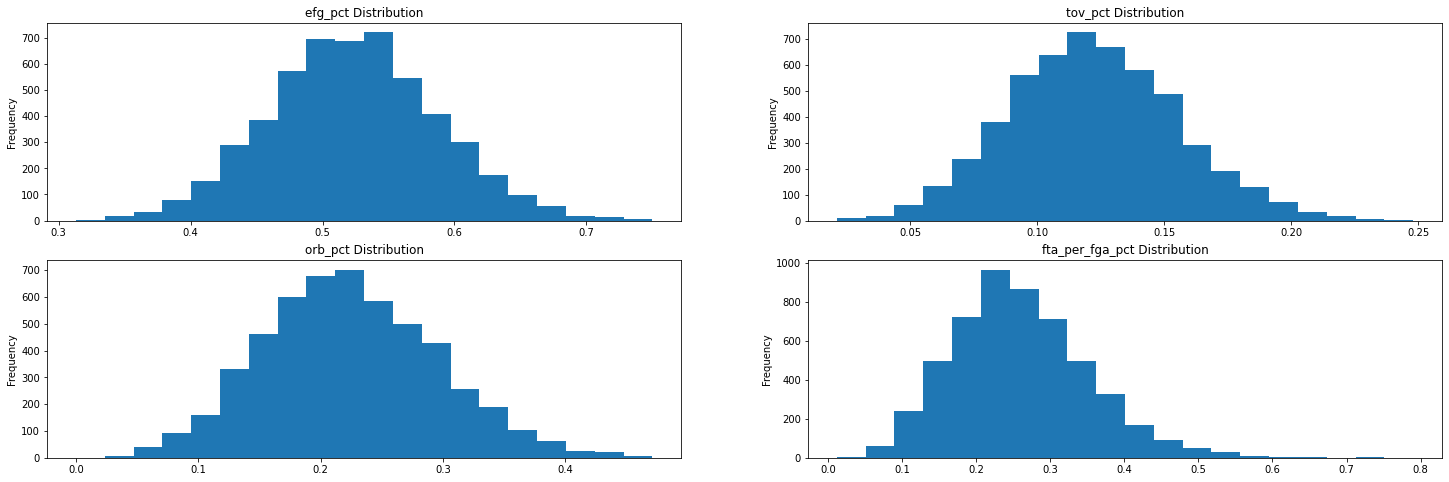

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(25, 8))
axes.resize(1, 4)
for ax, col in zip (axes[0], [x for x in model_1_df.columns if x != "pts"]):
    model_1_df[col].plot(kind="hist", bins=20, ax=ax)
    ax.set_title(f"{col} Distribution")

In [13]:
X = model_1_df.iloc[:, :-1].values
Y = model_1_df.iloc[:, -1:].values

In [14]:
X.shape

(5248, 4)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=11)

In [16]:
model_1 = LinearRegression(normalize=True)

In [17]:
model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [18]:
model_1.score(X_test, y_test)

0.7107607407940051

In [19]:
score_predictions_series = model_1.predict(X)

In [20]:
predictions = pd.DataFrame(zip(Y, score_predictions_series), columns=["Score", "ŷ"], dtype=np.float64)

In [21]:
predictions["Squared_Error"] = ((predictions["Score"] - predictions["ŷ"])**2)**.5

In [22]:
# Average Error of Our Score Predictions
predictions.Squared_Error.mean()

5.126904231809738

In [23]:
# Median Error of Our Score Predictions (50th percentile outcome)
predictions.Squared_Error.median()

4.17108529303087

In [24]:
predictions.Squared_Error.describe()

count    5248.000000
mean        5.126904
std         4.302635
min         0.001326
25%         1.997326
50%         4.171085
75%         7.145596
max        49.193843
Name: Squared_Error, dtype: float64

In [25]:
model_1.coef_

array([[ 154.145762  , -121.6372134 ,   41.2235126 ,   28.65572043]])

Text(0.5, 0.98, 'Model 1 Error Distibution')

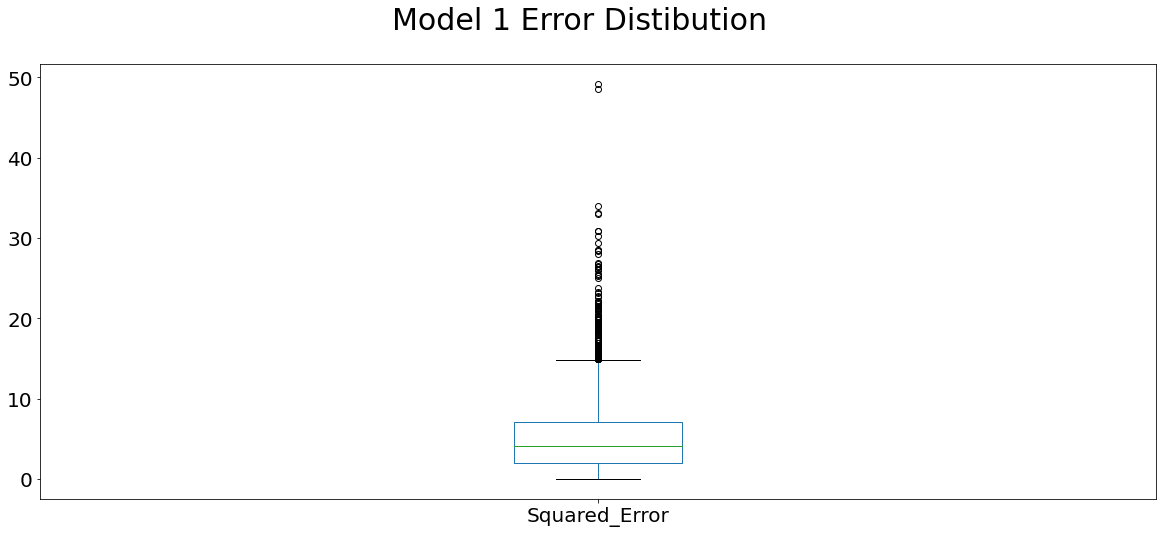

In [26]:
predictions.plot(y="Squared_Error", kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 1 Error Distibution", size=30)

Text(0.5, 0.98, 'Model 1 Prediction (ŷ) vs. Real Scores')

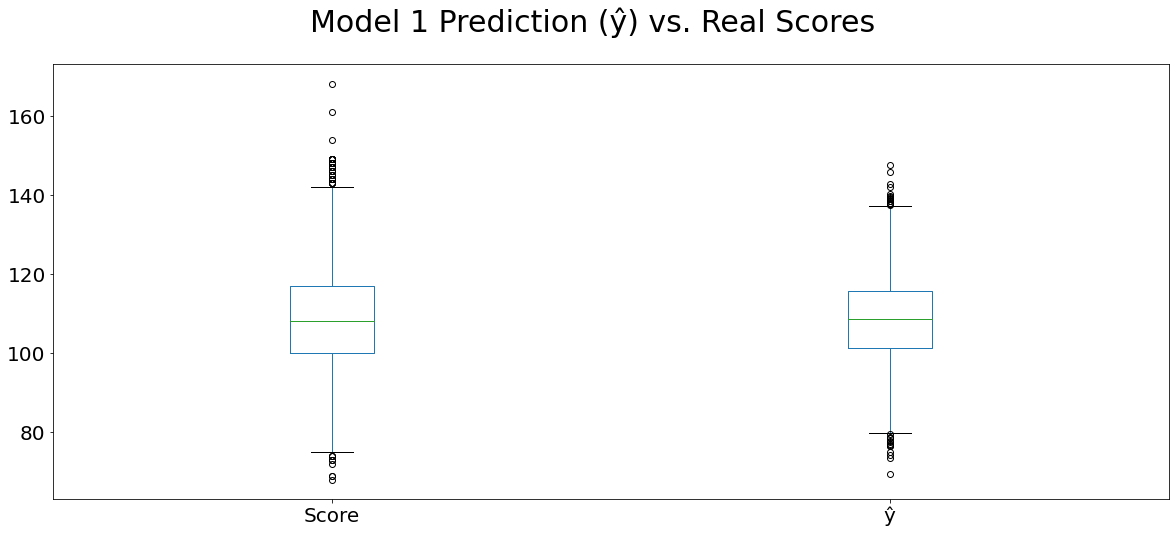

In [27]:
predictions.plot(y=["Score", "ŷ"], kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 1 Prediction (ŷ) vs. Real Scores", size=30)

In [28]:
predictions.sort_values("Squared_Error", ascending=False).head(20)

,Score,ŷ,Squared_Error
1708,168.0,118.806157,49.193843
1709,161.0,112.440255,48.559745
671,148.0,114.045998,33.954002
1561,149.0,115.928855,33.071145
1294,148.0,114.975932,33.024068
799,140.0,109.116515,30.883485
2371,154.0,123.148299,30.851701
670,147.0,116.804558,30.195442
1541,138.0,108.600003,29.399997
1295,139.0,110.484979,28.515021


### Model 1 Evaluation
1. Basing A Score Prediction on Percentages Alone Still Leaves Me with A Large Amount of Outliers, some as high as 50.
2. Judging from the Distibution of Scores vs. My Prediction, the first model suffers the most from the highest scoring games. It can only adjust so far off the mean score to compensate for better shooting,
3. The Model Needs a Time Component to Factor In Overtime Games and Games With More Possessions.

In [29]:
df

,Team,team_abbv,OppTeam,opp_abbv,date,minutes_played,fg,fga,fg_pct,fg3,...,Worst_Odds_OU,pts,Result,Spread,Total,playoffs,home_team_bin,NBA_season,game_code,OT
0,Dallas,DAL,Toronto,TOR,2018-10-26,240.0,38.0,92.0,0.413,12.0,...,-110.0,107.0,L,-9.0,223.0,0,0,18-19,201810260TOR,0
1,Toronto,TOR,Dallas,DAL,2018-10-26,240.0,44.0,91.0,0.484,11.0,...,-117.0,116.0,W,9.0,223.0,0,1,18-19,201810260TOR,0
2,Boston,BOS,Toronto,TOR,2018-10-19,240.0,40.0,99.0,0.404,14.0,...,-115.0,101.0,L,-12.0,214.0,0,0,18-19,201810190TOR,0
3,Toronto,TOR,Boston,BOS,2018-10-19,240.0,43.0,92.0,0.467,13.0,...,-115.0,113.0,W,12.0,214.0,0,1,18-19,201810190TOR,0
4,Cleveland,CLE,Toronto,TOR,2018-10-17,240.0,34.0,85.0,0.400,7.0,...,-115.0,104.0,L,-12.0,220.0,0,0,18-19,201810170TOR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5243,New York,NYK,Cleveland,CLE,2018-04-09,240.0,46.0,87.0,0.529,11.0,...,-111.0,109.0,L,-14.0,232.0,0,1,17-18,201804090NYK,0
5244,New York,NYK,L.A. Clippers,LAC,2018-03-02,240.0,41.0,89.0,0.461,11.0,...,-110.0,105.0,L,-23.0,233.0,0,0,17-18,201803020LAC,0
5245,L.A. Clippers,LAC,New York,NYK,2018-03-02,240.0,50.0,89.0,0.562,9.0,...,-111.0,128.0,W,23.0,233.0,0,1,17-18,201803020LAC,0
5246,Toronto,TOR,Detroit,DET,2018-03-07,265.0,45.0,101.0,0.446,12.0,...,-110.0,121.0,W,2.0,240.0,0,0,17-18,201803070DET,1


In [30]:
# reference: https://fansided.com/2015/12/21/nylon-calculus-101-possessions/#:~:text=How%20does%20stats.NBA.com,correctly%20factor%20in%20team%20rebounds.
def possessionCalculator(df):
    # equation used to properly account for rebounds as a factor of overall possessions.
    # original formula:
        # 0.5 * (FGA + (0.4*FTA) - 1.07*(ORB / (ORB  + Opp DRB)) * (FGA - FG) + TOV) + (Opp FGA + (0.4*Opp FTA) - 1.07*(Opp ORB / (Opp ORB + DRB)) * (Opp FGA - Opp FG) + Opp TOV)
    home_teams = df[lambda x: x.home_team_bin == 1].loc[:, ["fg", "fga", "fta", "orb", "drb", "tov", "game_code"]]
    away_teams = df[lambda x: x.home_team_bin == 0].loc[:, ["fg", "fga", "fta", "orb", "drb", "tov", "game_code"]]
    df_game_by_game = home_teams.merge(away_teams, on="game_code", suffixes=("_home", "_away")).sort_index()
    
    df_game_by_game["game_possessions"] = 0.5 * ((df_game_by_game["fga_home"] + 0.4*df_game_by_game["fta_home"] - (1.07* (df_game_by_game["orb_home"] / (df_game_by_game["orb_home"] + df_game_by_game["drb_away"])))\
                                                  * (df_game_by_game["fga_home"] - df_game_by_game["fg_home"]) + df_game_by_game["tov_home"] +\
                                                  (df_game_by_game["fga_away"] + 0.4*df_game_by_game["fta_away"] - (1.07* (df_game_by_game["orb_away"] / (df_game_by_game["orb_away"] + df_game_by_game["drb_home"])))\
                                                   * (df_game_by_game["fga_away"] - df_game_by_game["fg_away"]) + df_game_by_game["tov_away"]
                                                  )))
    
    return df.merge(df_game_by_game.loc[:, ["game_code", "game_possessions"]], on="game_code")

<AxesSubplot:ylabel='Frequency'>

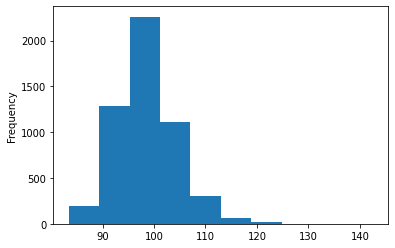

In [31]:
possessionCalculator(df).game_possessions.plot(kind="hist")

In [32]:
df = possessionCalculator(df)

In [33]:
# reference: https://www.basketball-reference.com/boxscores/201811020BRK.html
# Our New Game Possessions Column Matches That of the Pace Statistic on Basketball Reference
df[df.game_code == "201811020BRK"]

,Team,team_abbv,OppTeam,opp_abbv,date,minutes_played,fg,fga,fg_pct,fg3,...,pts,Result,Spread,Total,playoffs,home_team_bin,NBA_season,game_code,OT,game_possessions
312,Houston,HOU,Brooklyn,BRK,2018-11-02,240.0,41.0,83.0,0.494,15.0,...,119.0,W,8.0,230.0,0,0,18-19,201811020BRK,0,92.411904
313,Brooklyn,BRK,Houston,HOU,2018-11-02,240.0,42.0,85.0,0.494,15.0,...,111.0,L,-8.0,230.0,0,1,18-19,201811020BRK,0,92.411904


## Model 2: Four Factors + Possession Adjustments
* There is no universally accepted parameter for possessions, but the above function is the way basketball reference tracks possessions (which can be confirmed by comparing the game_possessions column and their game pace statistic). 
    
* All possessions should lead to a scoring attempt via a shot (fga or fta), a continuation of the possession (or a possession 'reset' via an offensive rebound) or a change in possession via a turnover or a defensive rebound.
    
* Having a possession estimate should also help our regression model by feeding in a time variable to better adjust its scoring projections.
    * Since the first model only includes rates, the model assumes that all games take place over equivalent time, but for basketball the chance of a tie is more probable due to the frequency of scoring and all ties must be resolved through, in theory, unlimited overtimes until there is no longer one.
        


In [34]:
model_2_df = df.loc[:, ['efg_pct', 'tov_pct', 'orb_pct', 'fta_per_fga_pct', 'game_possessions', 'pts']]

In [35]:
model_2_df

,efg_pct,tov_pct,orb_pct,fta_per_fga_pct,game_possessions,pts
0,0.478,12.0,20.8,0.261,100.721685,107.0
1,0.544,10.7,26.1,0.220,100.721685,116.0
2,0.475,11.9,30.2,0.101,97.780277,101.0
3,0.538,10.7,26.7,0.207,97.780277,113.0
4,0.441,13.5,28.6,0.459,100.326146,104.0
...,...,...,...,...,...,...
5243,0.592,13.2,18.6,0.138,97.237820,109.0
5244,0.522,15.0,21.3,0.180,97.641305,105.0
5245,0.612,9.9,37.8,0.270,97.641305,128.0
5246,0.505,7.5,20.8,0.208,105.659887,121.0


In [36]:
X = model_2_df.iloc[:, :-1].values
Y = model_2_df.iloc[:, -1:].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=17)

In [38]:
model_2 = LinearRegression(normalize=True)

In [39]:
model_2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [40]:
model_2.score(X_test, y_test)

0.9583279070175514

In [41]:
predictions_2 = model_2.predict(X)

In [42]:
predictions_2_df = pd.DataFrame(zip(Y, predictions_2), columns=["Score", "ŷ"], dtype=np.float64)

In [43]:
predictions_2_df["Squared_Error"] = ((predictions_2_df["Score"] - predictions_2_df["ŷ"])**2)**.5

In [44]:
predictions_2_df.Squared_Error.describe()

count    5248.000000
mean        2.071993
std         1.597878
min         0.000119
25%         0.826481
50%         1.722928
75%         2.954906
max        10.863140
Name: Squared_Error, dtype: float64

Text(0.5, 0.98, 'Model 2 Error Distibution')

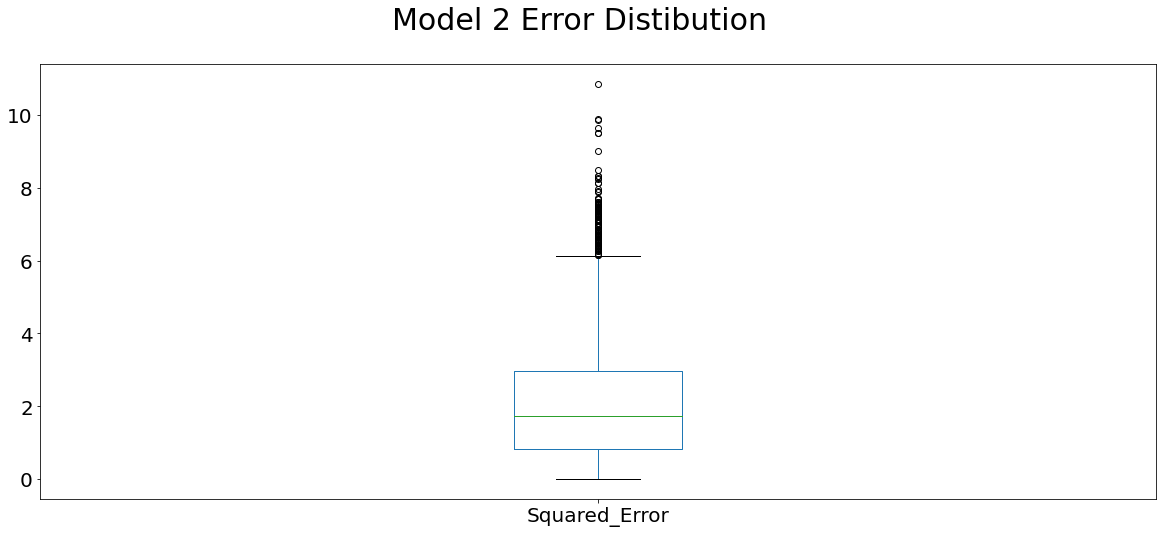

In [45]:
predictions_2_df.plot(y="Squared_Error", kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 2 Error Distibution", size=30)

Text(0.5, 0.98, 'Model 2 Prediction (ŷ) vs. Real Scores')

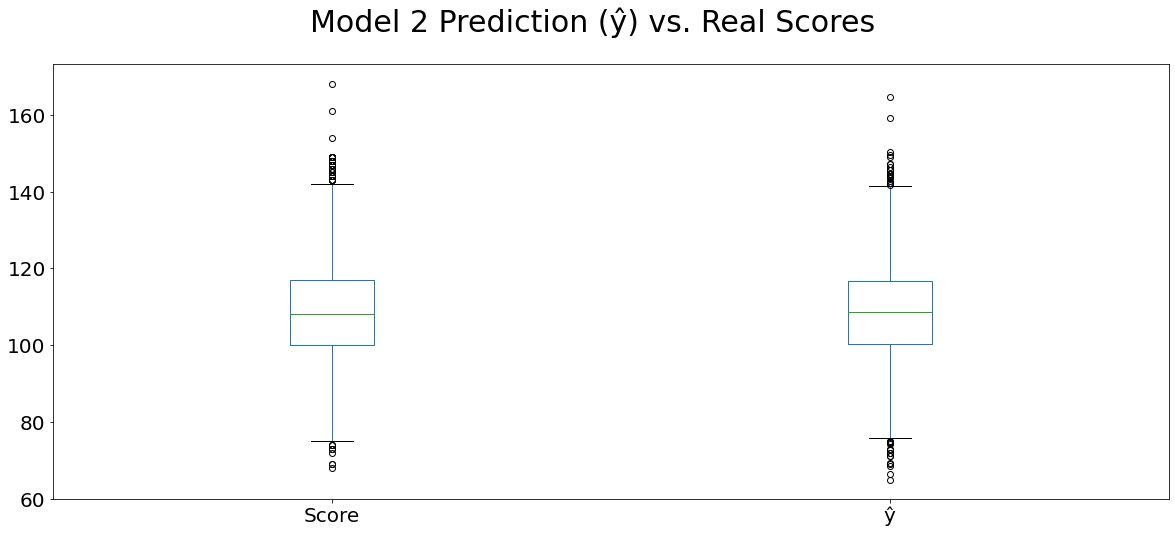

In [46]:
predictions_2_df.plot(y=["Score", "ŷ"], kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 2 Prediction (ŷ) vs. Real Scores", size=30)

Text(0.5, 1.0, 'Comparison of the Distribution of the Squared Errors for Both Models')

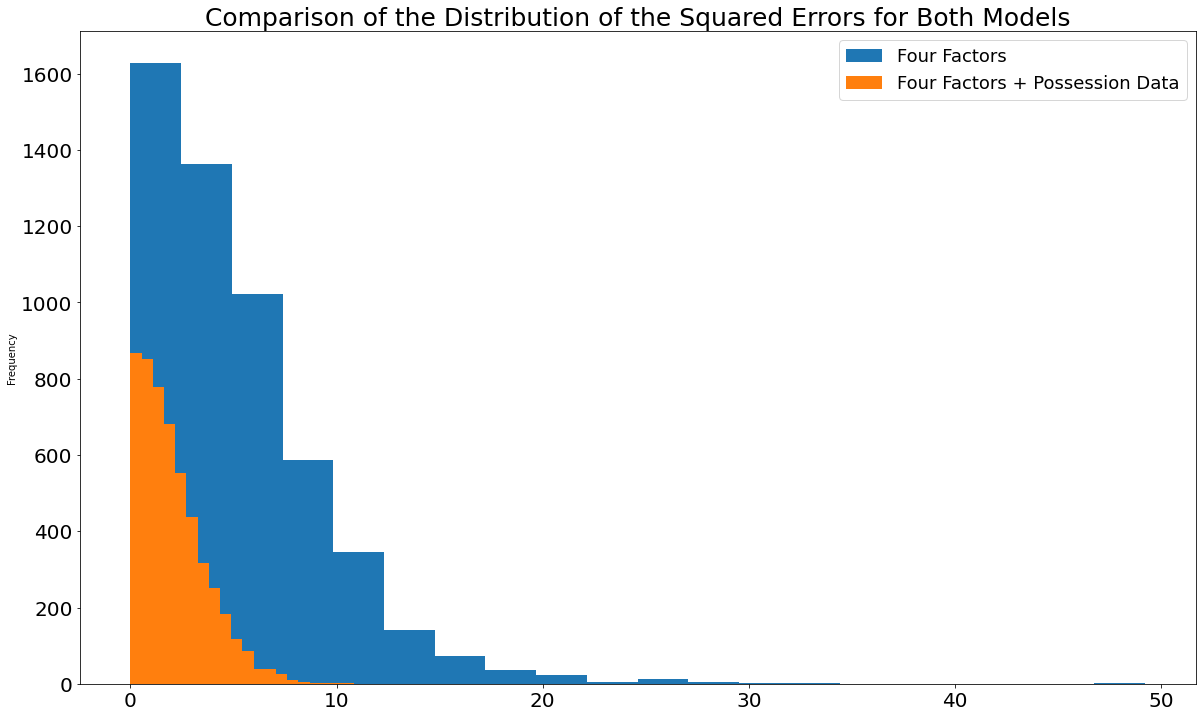

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
predictions.Squared_Error.plot(kind="hist", ax=ax, fontsize=20, bins=20)
predictions_2_df.Squared_Error.plot(kind="hist", ax=ax, bins=20)
ax.legend(["Four Factors", "Four Factors + Possession Data"], fontsize=18)
ax.set_title("Comparison of the Distribution of the Squared Errors for Both Models", fontsize=25)

<AxesSubplot:title={'center':'Model 1'}, xlabel='Squared_Error', ylabel='Score'>

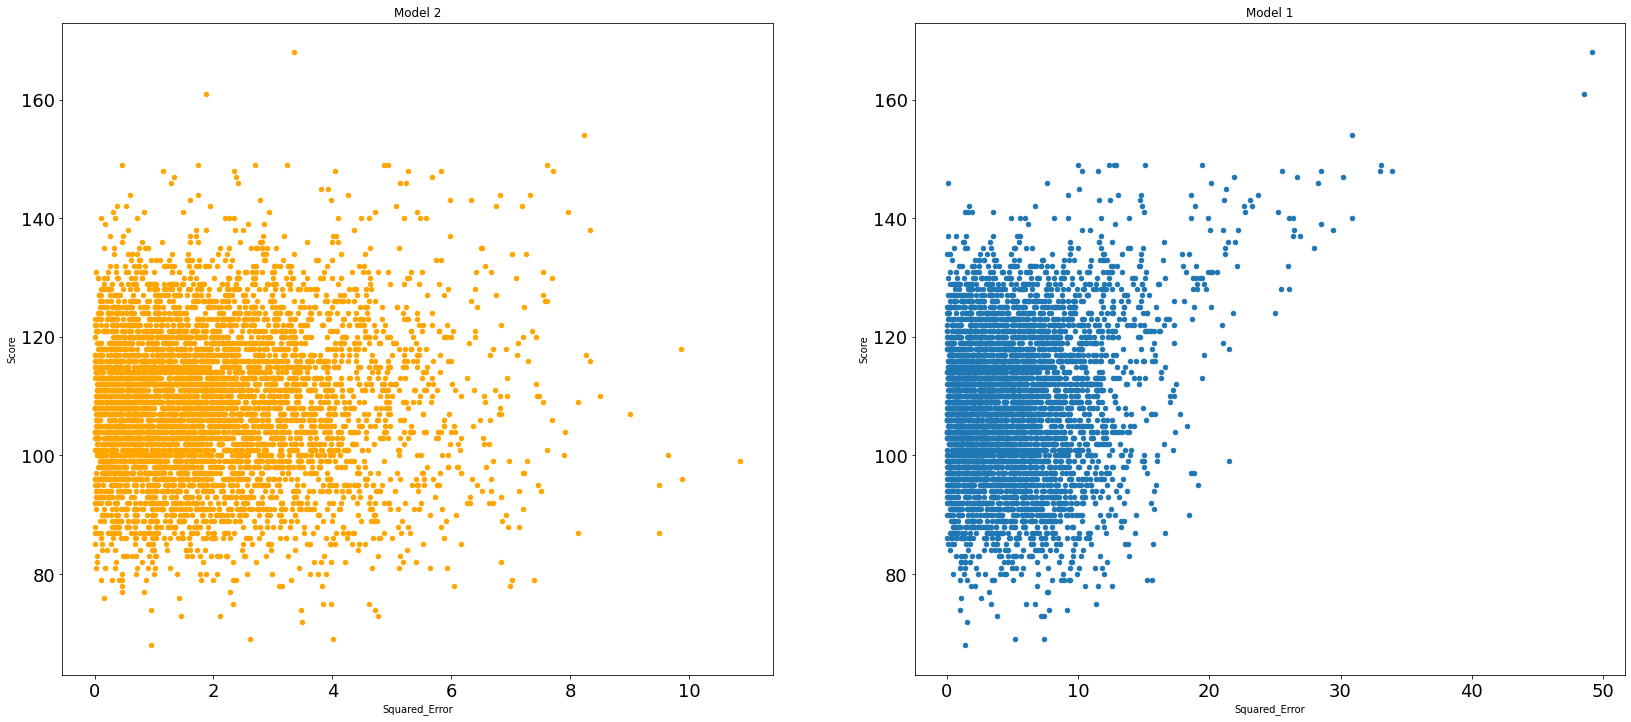

In [48]:
# Model 2's Residuals Show An Even Scatter and No Fanning Pattern; Model 1's Residuals Show A Fanning Pattern Indicating Worse Predictions for Higher Scores
fig, ax = plt.subplots(1, 2, figsize=(28, 12))
predictions_2_df.plot(kind="scatter", x="Squared_Error", y="Score", color="orange", ax=ax[0], title="Model 2", fontsize=18)
predictions.plot(kind="scatter", x="Squared_Error", y="Score", ax=ax[1], title="Model 1", fontsize=18)

In [49]:
model_2_df.corr()

,efg_pct,tov_pct,orb_pct,fta_per_fga_pct,game_possessions,pts
efg_pct,1.000000,0.110294,-0.066411,-0.019037,0.024412,0.728471
tov_pct,0.110294,1.000000,0.017006,0.076284,0.094381,-0.214221
orb_pct,-0.066411,0.017006,1.000000,0.008772,-0.094900,0.181438
fta_per_fga_pct,-0.019037,0.076284,0.008772,1.000000,0.125056,0.168352
game_possessions,0.024412,0.094381,-0.094900,0.125056,1.000000,0.473798
pts,0.728471,-0.214221,0.181438,0.168352,0.473798,1.000000


<AxesSubplot:ylabel='Frequency'>

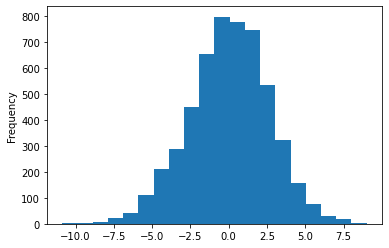

In [50]:
predictions_2_df.assign(Error = lambda x: x.Score - x["ŷ"]).Error.plot(kind="hist", bins=20)

In [51]:
predictions

,Score,ŷ,Squared_Error
0,107.0,101.216026,5.783974
1,116.0,113.980892,2.019108
2,101.0,100.165321,0.834679
3,113.0,112.930834,0.069166
4,104.0,102.577342,1.422658
...,...,...,...
5243,109.0,112.897426,3.897426
5244,105.0,102.234328,2.765672
5245,128.0,131.691839,3.691839
5246,121.0,109.332883,11.667117


In [52]:
predictions_2_df

,Score,ŷ,Squared_Error
0,107.0,103.479856,3.520144
1,116.0,117.154492,1.154492
2,101.0,101.495667,0.495667
3,113.0,113.122906,0.122906
4,104.0,103.425858,0.574142
...,...,...,...
5243,109.0,111.794018,2.794018
5244,105.0,101.355382,3.644618
5245,128.0,132.278388,4.278388
5246,121.0,117.946591,3.053409


In [53]:
# Should be able to merge on Index if True
(df.pts == predictions_2_df.Score).value_counts()

True    5248
dtype: int64

In [54]:
# Should be able to merge on Index if True
(df.pts == predictions.Score).value_counts()

True    5248
dtype: int64

In [55]:
# Rename ŷ to Predictions, Drop Score and Rename Sq. Error to SE. Prepend Model # to columns
predictions = predictions.drop("Score", axis=1)
predictions = predictions.rename(columns={"ŷ": "Prediction", "Squared_Error": "SE"})
predictions.columns = ["Model_1_" + x for x in predictions.columns]

In [56]:
# Rename ŷ to Predictions, Drop Score and Rename Sq. Error to SE. Prepend Model # to columns
predictions_2_df = predictions_2_df.drop("Score", axis=1)
predictions_2_df = predictions_2_df.rename(columns={"ŷ": "Prediction", "Squared_Error": "SE"})
predictions_2_df.columns = ["Model_2_" + x for x in predictions_2_df.columns]

In [57]:
predictions

,Model_1_Prediction,Model_1_SE
0,101.216026,5.783974
1,113.980892,2.019108
2,100.165321,0.834679
3,112.930834,0.069166
4,102.577342,1.422658
...,...,...
5243,112.897426,3.897426
5244,102.234328,2.765672
5245,131.691839,3.691839
5246,109.332883,11.667117


In [58]:
predictions_2_df

,Model_2_Prediction,Model_2_SE
0,103.479856,3.520144
1,117.154492,1.154492
2,101.495667,0.495667
3,113.122906,0.122906
4,103.425858,0.574142
...,...,...
5243,111.794018,2.794018
5244,101.355382,3.644618
5245,132.278388,4.278388
5246,117.946591,3.053409


In [59]:
model_predictions_df = pd.merge(predictions, predictions_2_df, left_index=True, right_index=True)

In [60]:
df_w_models = df.merge(model_predictions_df, right_index=True, left_index=True)

In [61]:
df_w_models.loc[:, ["Team", "OppTeam", "date", "game_code", "pts", "Model_1_Prediction", "Model_2_Prediction", "Model_1_SE", "Model_2_SE"]]

,Team,OppTeam,date,game_code,pts,Model_1_Prediction,Model_2_Prediction,Model_1_SE,Model_2_SE
0,Dallas,Toronto,2018-10-26,201810260TOR,107.0,101.216026,103.479856,5.783974,3.520144
1,Toronto,Dallas,2018-10-26,201810260TOR,116.0,113.980892,117.154492,2.019108,1.154492
2,Boston,Toronto,2018-10-19,201810190TOR,101.0,100.165321,101.495667,0.834679,0.495667
3,Toronto,Boston,2018-10-19,201810190TOR,113.0,112.930834,113.122906,0.069166,0.122906
4,Cleveland,Toronto,2018-10-17,201810170TOR,104.0,102.577342,103.425858,1.422658,0.574142
...,...,...,...,...,...,...,...,...,...
5243,New York,Cleveland,2018-04-09,201804090NYK,109.0,112.897426,111.794018,3.897426,2.794018
5244,New York,L.A. Clippers,2018-03-02,201803020LAC,105.0,102.234328,101.355382,2.765672,3.644618
5245,L.A. Clippers,New York,2018-03-02,201803020LAC,128.0,131.691839,132.278388,3.691839,4.278388
5246,Toronto,Detroit,2018-03-07,201803070DET,121.0,109.332883,117.946591,11.667117,3.053409


In [62]:
# Right now Spread is really Margin of Victory
df_w_models.loc[:, ["Team", "OppTeam", "pts", "Spread"]]

,Team,OppTeam,pts,Spread
0,Dallas,Toronto,107.0,-9.0
1,Toronto,Dallas,116.0,9.0
2,Boston,Toronto,101.0,-12.0
3,Toronto,Boston,113.0,12.0
4,Cleveland,Toronto,104.0,-12.0
...,...,...,...,...
5243,New York,Cleveland,109.0,-14.0
5244,New York,L.A. Clippers,105.0,-23.0
5245,L.A. Clippers,New York,128.0,23.0
5246,Toronto,Detroit,121.0,2.0


In [63]:
#Flip Spread to Match Market Lines (a negative spread line represents the predicted winner by minus the spreadline)
df_w_models["Spread"] = df_w_models["Spread"] * -1

In [64]:
df_w_models.loc[:, ["Team", "OppTeam", "pts", "Spread"]].head(10)

,Team,OppTeam,pts,Spread
0,Dallas,Toronto,107.0,9.0
1,Toronto,Dallas,116.0,-9.0
2,Boston,Toronto,101.0,12.0
3,Toronto,Boston,113.0,-12.0
4,Cleveland,Toronto,104.0,12.0
5,Toronto,Cleveland,116.0,-12.0
6,Charlotte,Toronto,106.0,21.0
7,Toronto,Charlotte,127.0,-21.0
8,Minnesota,Toronto,105.0,7.0
9,Toronto,Minnesota,112.0,-7.0


In [65]:
# Create Open, Average and Worst Score Projections for each team based on their associated pairs of Over/Under Projections and Spread Projections

In [66]:
# We Can Reverse Engineer This By Halving the Over/Under and Adding the Additive Inverse of the Spread
df_w_models["Open_Score_Projection"] = (df_w_models["Open_Line_OU"]/2) + (-1 * df_w_models["Open_Line_Spread"])
df_w_models["Average_Score_Projection"] = (df_w_models["Average_Line_OU"]/2) + (-1 * df_w_models["Average_Line_Spread"])
df_w_models["Best_Score_Projection"] = (df_w_models["Best_Line_OU"]/2) + (-1 * df_w_models["Best_Line_Spread"])
df_w_models["Worst_Score_Projection"] = (df_w_models["Worst_Line_OU"]/2) + (-1 * df_w_models["Worst_Line_Spread"])

In [67]:
# Calculate Market Error 

In [68]:
#df_w_models.assign(open_error = lambda x: ((x.pts - x.Open_Score_Projection)**2)**.5).open_error.plot(kind="hist", alpha=.6, bins=25, figsize=(25, 10))
#df_w_models.assign(avg_error = lambda x: ((x.pts - x.Avg_Score_Projection)**2)**.5).avg_error.plot(kind="hist", alpha=.4, bins=25)
#df_w_models.assign(best_error = lambda x: ((x.pts - x.Best_Score_Projection)**2)**.5).best_error.plot(kind="hist", alpha=.3, bins=25)
#df_w_models.assign(worst_error = lambda x: ((x.pts - x.Worst_Score_Projection)**2)**.5).worst_error.plot(kind="hist", alpha=.3, bins=25)
#plt.legend(["Open Market Error", "Avg. Market Error", "Best Line Error", "Worst Line Error"])

In [69]:
df_w_models.columns[50:100]

Index(['Pinnacle_Odds_Spread', 'Heritage_Line_Spread', 'Heritage_Odds_Spread',
       'Bovada_Line_Spread', 'Bovada_Odds_Spread', 'Betonline_Line_Spread',
       'Betonline_Odds_Spread', 'Average_Line_Spread', 'Average_Odds_Spread',
       'Best_Line_Spread', 'Worst_Line_Spread', 'Best_Odds_Spread',
       'Worst_Odds_Spread', 'PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU',
       'Pinnacle_Line_OU', 'Pinnacle_Odds_OU', 'Heritage_Line_OU',
       'Heritage_Odds_OU', 'Bovada_Line_OU', 'Bovada_Odds_OU',
       'Betonline_Line_OU', 'Betonline_Odds_OU', 'Average_Line_OU',
       'Average_Odds_OU', 'Best_Line_OU', 'Worst_Line_OU', 'Best_Odds_OU',
       'Worst_Odds_OU', 'pts', 'Result', 'Spread', 'Total', 'playoffs',
       'home_team_bin', 'NBA_season', 'game_code', 'OT', 'game_possessions',
       'Model_1_Prediction', 'Model_1_SE', 'Model_2_Prediction', 'Model_2_SE',
       'Open_Score_Projection', 'Average_Score_Projection',
       'Best_Score_Projection', 'Worst_Score_Projection'],
  

In [70]:
df_w_models.loc[:, [x for x in df_w_models.columns if "Average" in x]].describe()

,Average_ML,Average_Line_Spread,Average_Odds_Spread,Average_Line_OU,Average_Odds_OU,Average_Score_Projection
count,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000
mean,-44.176810,0.000023,-107.635514,217.003700,-107.571322,108.501827
std,425.165874,7.054343,1.945502,9.800889,1.677018,8.589430
min,-3937.330000,-18.750000,-116.500000,190.000000,-115.500000,83.060000
25%,-228.062500,-5.620000,-109.000000,210.120000,-108.750000,102.060000
50%,-105.585000,0.000000,-107.500000,216.750000,-107.500000,108.130000
75%,195.000000,5.620000,-106.250000,224.000000,-106.250000,114.620000
max,1877.000000,18.750000,-102.500000,243.620000,-102.500000,134.000000


In [71]:
df_w_models[lambda x: abs(x.Average_ML) < 100].sort_values("Average_ML").Average_ML

4217   -73.75
3399   -72.00
3889   -68.25
1661   -65.25
3051   -64.25
        ...  
4216    55.75
2355    55.75
4147    56.00
1211    56.50
94      56.75
Name: Average_ML, Length: 160, dtype: float64

In [72]:
df_w_models.loc[52:57, [x for x in df_w_models.columns if "_ML" in x]]

,PercentBet_ML,Open_ML,Pinnacle_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_ML,Best_ML,Worst_ML
52,44.7,140.0,-103.0,100.0,100.0,-107.0,-2.50,100.0,-107.0
53,55.3,-160.0,-107.0,-120.0,-120.0,-113.0,-115.00,-107.0,-120.0
54,41.9,410.0,251.0,250.0,255.0,245.0,250.25,255.0,245.0
55,58.1,-540.0,-284.0,-310.0,-310.0,-290.0,-298.50,-284.0,-310.0
56,51.0,148.0,144.0,135.0,135.0,145.0,139.75,145.0,135.0
57,49.0,-170.0,-160.0,-155.0,-155.0,-165.0,-158.75,-155.0,-165.0


In [73]:
def oddsFlip(odds):
    if odds < 0:
        return round((100/abs(odds))*100, 2)
    else:
        return odds 

In [74]:
df_w_models.Average_ML.apply(abs).describe()

count    5248.000000
mean      309.762111
std       294.528658
min         0.500000
25%       145.500000
50%       210.000000
75%       352.812500
max      3937.330000
Name: Average_ML, dtype: float64

In [75]:
# hotfix for Average ML < 100, indicates the same team is favored at least one book
def fixMoneyLine(df):
    # See if Abs(Average Column) < 100
    columns_to_fix = df[df.Average_ML.apply(abs) < 100].loc[:, ["Pinnacle_ML", "Heritage_ML", "Bovada_ML", "Betonline_ML"]]
    _temp_df = pd.DataFrame()
    for book in columns_to_fix.columns:
        _temp_df[book] = columns_to_fix[book].apply(oddsFlip)
    
    _temp_df["Fixed_ML"] = round(_temp_df.mean(axis=1), 2)
    new_df = df.merge(_temp_df["Fixed_ML"], "left", left_index=True, right_index=True)
    new_df.Fixed_ML = new_df.Fixed_ML.fillna(new_df.Average_ML)
    new_df = new_df.drop("Average_ML", axis=1)
    new_df = new_df.rename(columns={"Fixed_ML": "Average_ML"})
    return new_df

In [76]:
df_w_models_fixed = fixMoneyLine(df_w_models)

In [77]:
df_w_models_fixed.Average_ML.apply(abs).describe()

count    5248.000000
mean      311.515433
std       293.063320
min        82.090000
25%       145.500000
50%       210.000000
75%       352.812500
max      3937.330000
Name: Average_ML, dtype: float64

In [78]:
# Currently: We have a Good Model knowing the end result of Four Factors and a Possessions Estimate. 
# Just knowing the Four Factors provides us with a similar residual spread of the market.
# Can We use past Possession data as well as Four Factors of a team's recent games to better project the game in question.
# The main mathematical goal here will be to achieve a residuial mean smaller than that of the markets so that over time, we known our model in the long run better predict the score than the market.

<h2 style="color: orange">Comparing Lines, Over/Unders and Bookies with Our 2nd Model</h2>

<ul><b>Givens</b>
    <li>Total Projections (over/under), Game Projections (spread) and Winning Projections (moneyline)</li>
    <li>We have these metrics from 4 offshore Betting Houses: Pinnacle, Hertiage, Bovada and Betonline</li>
    <li>From this information we have a given opening line for each projection, an average metric aggregating the book's individual numbers and both a min/max showing the best and worst line for a specific team for a specific game</li>
    <li>From this information and our associated compiled model, we can then: backtest our model strategy with the true market rates at each book and compute the losses and winning we would've taken given which side of the spread we fall on</li>
</ul>

In [79]:
# We have a multitude of Spreads split up into 2 Categories:
    # 1. Aggregate Spreads: Best and Worst (Max and min), Average Spread and Opening Spread (the initial line)
    # 2. Actual Books Spread with their corresponding Lines: How many points they are giving and the cost for that line

#### Saturday's Goals:
* Write Function to Evaluate Predictions
    * Turn Score into Spread, Moneyline and Over-Under Pick
        * Evaluate Picks Based on Results
        * Evalutae Picks Based on Bookmakers
        * Evaulate Picks Based on Summary Metrics (performance against opening lines, average lines, best lines and worst lines)

In [80]:
#!git add .
#!git commit -m "Updated Model_Stage Notebook With Saturday's Goals"
#!git push

In [81]:
df_w_models_fixed.columns

Index(['Team', 'team_abbv', 'OppTeam', 'opp_abbv', 'date', 'minutes_played',
       'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct',
       'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'ts_pct', 'efg_pct',
       'fg3a_per_fga_pct', 'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct',
       'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'off_rtg',
       'def_rtg', 'pf', 'PercentBet_ML', 'Open_ML', 'Pinnacle_ML',
       'Heritage_ML', 'Bovada_ML', 'Betonline_ML', 'Best_ML', 'Worst_ML',
       'PercentBet_Spread', 'Open_Line_Spread', 'Open_Odds_Spread',
       'Pinnacle_Line_Spread', 'Pinnacle_Odds_Spread', 'Heritage_Line_Spread',
       'Heritage_Odds_Spread', 'Bovada_Line_Spread', 'Bovada_Odds_Spread',
       'Betonline_Line_Spread', 'Betonline_Odds_Spread', 'Average_Line_Spread',
       'Average_Odds_Spread', 'Best_Line_Spread', 'Worst_Line_Spread',
       'Best_Odds_Spread', 'Worst_Odds_Spread', 'PercentBet_OU',
       'Open_Line_OU', 'Open_Odds_OU

In [82]:
evaluation_df = df_w_models_fixed.loc[:, ['team_abbv', 'opp_abbv',
                                           'PercentBet_ML', 'Open_ML',
                                           'Pinnacle_ML', 'Heritage_ML', 'Bovada_ML', 'Betonline_ML',
                                           'Average_ML', 'Best_ML', 'Worst_ML',
                                           'PercentBet_Spread', 'Open_Line_Spread', 'Open_Odds_Spread',
                                           'Pinnacle_Line_Spread', 'Pinnacle_Odds_Spread', 'Heritage_Line_Spread','Heritage_Odds_Spread',
                                           'Bovada_Line_Spread', 'Bovada_Odds_Spread', 'Betonline_Line_Spread', 'Betonline_Odds_Spread',
                                           'Average_Line_Spread', 'Average_Odds_Spread', 'Best_Line_Spread', 'Worst_Line_Spread',
                                           'Best_Odds_Spread', 'Worst_Odds_Spread',
                                           'PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU',
                                           'Pinnacle_Line_OU', 'Pinnacle_Odds_OU', 'Heritage_Line_OU', 'Heritage_Odds_OU',
                                           'Bovada_Line_OU', 'Bovada_Odds_OU', 'Betonline_Line_OU', 'Betonline_Odds_OU',
                                           'Average_Line_OU', 'Average_Odds_OU', 'Best_Line_OU', 'Worst_Line_OU',
                                           'Best_Odds_OU', 'Worst_Odds_OU',
                                           'pts', 'Result', 'Spread', 'Total',
                                           'playoffs', 'home_team_bin', 'NBA_season', 'game_code', 'OT', 'date',
                                           'Model_1_Prediction', 'Model_2_Prediction']]

In [83]:
evaluation_df.Result = evaluation_df.Result.apply(lambda x: 1 if x == "W" else 0)

In [84]:
# Create Separate Dfs with My Projections, the Books Market, Ground Truths and Regular Data
joining_cols = ["team_abbv", "game_code", "home_team_bin"]
point_estimates = ["Model_1_Prediction", "Model_2_Prediction"]
ground_truths_cols = joining_cols + ["pts", "Result", "Spread",  "Total"] + point_estimates
market_cols = ["Bovada", "Heritage", "Betonline", "Pinnacle", "Open", "Average", "Best", "Worst"] + joining_cols
markets_regex = "|".join([x for x in market_cols if x not in joining_cols])

In [85]:
truth_df = evaluation_df.loc[:, ground_truths_cols]

In [86]:
truth_df.query("home_team_bin == 1").merge(truth_df.query("home_team_bin == 0"), on=["game_code"], suffixes=("_home", "_away"))

,team_abbv_home,game_code,home_team_bin_home,pts_home,Result_home,Spread_home,Total_home,Model_1_Prediction_home,Model_2_Prediction_home,team_abbv_away,home_team_bin_away,pts_away,Result_away,Spread_away,Total_away,Model_1_Prediction_away,Model_2_Prediction_away
0,TOR,201810260TOR,1,116.0,1,-9.0,223.0,113.980892,117.154492,DAL,0,107.0,0,9.0,223.0,101.216026,103.479856
1,TOR,201810190TOR,1,113.0,1,-12.0,214.0,112.930834,113.122906,BOS,0,101.0,0,12.0,214.0,100.165321,101.495667
2,TOR,201810170TOR,1,116.0,1,-12.0,220.0,117.081153,119.460941,CLE,0,104.0,0,12.0,220.0,102.577342,103.425858
3,TOR,201810220TOR,1,127.0,1,-21.0,233.0,124.172232,125.764171,CHO,0,106.0,0,21.0,233.0,101.684873,104.702619
4,TOR,201810240TOR,1,112.0,1,-7.0,217.0,113.183737,112.963969,MIN,0,105.0,0,7.0,217.0,105.197004,105.593421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,DET,201710180DET,1,102.0,1,-12.0,192.0,100.852721,102.154117,CHO,0,90.0,0,12.0,192.0,91.145586,87.958822
2620,GSW,201712220GSW,1,113.0,1,-7.0,219.0,111.416836,111.902767,LAL,0,106.0,0,7.0,219.0,105.213183,107.325538
2621,NYK,201804090NYK,1,109.0,0,14.0,232.0,112.897426,111.794018,CLE,0,123.0,1,-14.0,232.0,121.902850,119.944433
2622,LAC,201803020LAC,1,128.0,1,-23.0,233.0,131.691839,132.278388,NYK,0,105.0,0,23.0,233.0,102.234328,101.355382


In [ ]:
# pick a gambling metric: over/under, moneyline, spread or all-of-them <- We Want f(x) to Handle All Numbers
# pick a book: Pinnacle, Heritage, Bovada and Betonline <- Available Books
# pick an (optional) aggregate: Open, Average, Best or Worst
# feed into func: model_projection, comparison_number(s), aggregates=(True/False), ["O", "A", "B", "W"]
# Available Return Values: wins, winning percentages, and winnings (given dollar amount) all by wanted data slicers!  

def betEval(df, model_projection):
    '''
    Function for evaluating a model projection against a market and its aggregates.
    
    Parameters:
        - df: Dataframe of Team Results, Team Markets and Team Projections
        - model_projection: list of columns with point estimates
        - decision_numbers: list of columns with market numbers
    
    Returns: DataFrame With Wins, Winning Percentages and Money Won
    
    Evaluation Decision Rule Example:
    
    WINNING WAGERS:
    -----------------------------------------
    spread: -2.5 result: -4 -> WIN : -2.5 > -4
    spread: +2.5 result: -4 -> WIN : 2.5 > -4
    spread: +2.5 result: +1 -> WIN : 2.5 > 1
    
    LOSING WAGERS:
    -----------------------------------------
    spread: +2.5 result: +19 -> LOSS: 2.5 < 19
    spread: -2.5 result: +4 -> LOSS: -2.5 < 4
    spread: -2.5 result: -1 -> LOSS: -2.5 < -1
    
    PUSHING WAGERS:
    -----------------------------------------
    spread: -2.0 result: -2 -> PUSH: -2 = -2
    spread: +2.0 result: +2 -> PUSH: +2 = +2

    Thus, when spread > result, win; elif spread = result, push; else, loss.

    '''
    # Get Wanted Columns: (books, aggregations, ground_truths and model)
    picks_df = pd.DataFrame()
    books = ["Bovada", "Heritage", "Betonline", "Pinnacle"]
    aggregations = ["Open", "Average", "Best", "Worst"]
    book_lines = ["_ML", "_Line_Spread", "_Line_OU"] # "_Odds_Spread","Odds_OU"
    # Bring Data to a Game by Game Level, Picks Will be Made With Respect to Home Team
    ground_truths = df.loc[:, ["Result", "Spread", "Total","home_team_bin"]].query("home_team_bin == 1").reset_index(drop=True)
    ground_truths.Result = ground_truths.Result.apply(lambda x: 0 if x == "L" else 1)
    # Calculate Markets Based on My Model's Point Estimate
    _temp_df = df.loc[:, (model_projection + ["game_code", "home_team_bin"])]
    home_df = _temp_df.query("home_team_bin == 1")
    away_df = _temp_df.query("home_team_bin == 0")
    game_by_game_df = home_df.merge(away_df, on="game_code", suffixes=("_home", "_away")).reset_index(drop=True)
    for point_estimate in model_projection:
        game_by_game_df[f"{point_estimate}_Total"] = game_by_game_df[f"{point_estimate}_home"] + game_by_game_df[f"{point_estimate}_away"]
        # With Respect to Home
        game_by_game_df[f"{point_estimate}_Spread_home"] = game_by_game_df[f"{point_estimate}_away"] - game_by_game_df[f"{point_estimate}_home"]
        game_by_game_df[f"{point_estimate}_ML_home"] = (game_by_game_df[f"{point_estimate}_home"] > game_by_game_df[f"{point_estimate}_away"]) # Needs Fixing
        # With Respect to Away
        game_by_game_df[f"{point_estimate}_Spread_away"] = -game_by_game_df[f"{point_estimate}_Spread_home"]
        game_by_game_df[f"{point_estimate}_ML_away"]  = (game_by_game_df[f"{point_estimate}_away"] > game_by_game_df[f"{point_estimate}_home"])
        
        line_predictions = game_by_game_df.loc[:, [f"{point_estimate}_Spread_home", f"{point_estimate}_ML_home", f"{point_estimate}_Total"]]
        line_predictions.columns = [x.replace("_home", "") for x in line_predictions.columns]
        line_predictions = line_predictions.reset_index(drop=True)
        # Gather All Numbers offered by the Books
        for book in books:
            wanted_book_cols = [book+x for x in book_lines] + ["home_team_bin"]
            book_df = df.loc[:, wanted_book_cols].query("home_team_bin == 1")
            # Change ML to Implicit Prediction
            book_df[book+"_ML"] = book_df[book+"_ML"].apply(lambda x: 1 if x < 0 else 0)
            book_df = book_df.reset_index(drop=True)
            for prediction, market, result in zip(line_predictions.columns, book_df.columns, ground_truths.columns[:-1]):
                if "ML" not in market:
                    home_picker_series = (book_df[market] > line_predictions[prediction]).astype("int32") # Boolean of Whether I'd Pick the Home Team to win, cover and go over
                    picks_df[market] = (home_picker_series == (book_df[market] < ground_truths[result])).astype("int32")
                else:
                    

        # Gather All Numbers offered by the Aggregation of the Books
    for agg in aggregations:
            wanted_agg_cols = [agg+x for x in book_lines]  + ["home_team_bin"]
            agg_df = df.loc[:, wanted_agg_cols].query("home_team_bin == 1")
            # Change ML to Implicit Prediction
            agg_df[agg+"_ML"] = agg_df[agg+"_ML"].apply(lambda x: 1 if x < 100 else 0)
            agg_df = agg_df.reset_index(drop=True)
            for prediction, market, result in zip(line_predictions.columns, agg_df.columns, ground_truths.columns[:-1]):
                if "ML" not in market:
                    home_picker_series = (agg_df[market] > line_predictions[prediction]).astype("int32") # Boolean of Whether I'd Pick the Home Team to win, cover and go over
                    picks_df[market] = (home_picker_series == (agg_df[market] < ground_truths[result])).astype("int32")
                else:
                    home_picker_series = (agg_df[market] == line_predictions[prediction]).astype("int32")
                    picks_df[market] = (home_picker_series == (agg_df[market] == ground_truths[result])).astype("int32")
    
    return picks_df
        
    # Fix Moneyline Comparison
        # Right Now ML is really an Odds metric
        # We can reservert this odds to an assocaited market "pick" By seeing if it is > than 0
    # Comeup with Model on Imperfect Information   

In [ ]:
cpc = betEval(df_w_models_fixed, ["Model_1_Prediction", "Model_2_Prediction"])

In [ ]:
cpc

In [90]:
df_w_models_fixed.Result = df_w_models_fixed.Result.apply(lambda x: 1 if x == "W" else 0)

In [91]:
unit = 100
joining_cols = ["team_abbv", "game_code", "home_team_bin"]
# name the point estimate column name
point_estimate = "Model_1_Prediction"
# point estimate to market equivalents
model_markets = df_w_models_fixed.loc[:, [point_estimate, "team_abbv", "game_code", "home_team_bin"]]
    # pe to total
total = model_markets.groupby("game_code").sum()[f"{point_estimate}"].reset_index()
total = total.rename(columns={point_estimate: point_estimate + "_Line_OU"})
model_markets = model_markets.merge(total, on="game_code")
pick_flipper = {0: 1, 1:0} 
    # pe to spread
spread = model_markets.groupby("game_code")[f"{point_estimate}"].diff().bfill()
spread.name = point_estimate + "_Line_Spread"
model_markets[f"{point_estimate}_Line_Spread"]  = -spread
home_teams = (model_markets.query("home_team_bin == 1"))
away_teams = (model_markets.query("home_team_bin == 0"))
away_teams[f"{point_estimate}_Line_Spread"] = -away_teams[f"{point_estimate}_Line_Spread"]
model_markets = pd.concat([home_teams, away_teams], axis=0).sort_index()

    # pe to moneyline
home_df = model_markets.loc[:, [point_estimate, "team_abbv", "home_team_bin", "game_code"]].query("home_team_bin == 1")
away_df = model_markets.loc[:, [point_estimate, "team_abbv", "home_team_bin", "game_code"]].query("home_team_bin == 0")
game_df = home_df.merge(away_df, on=["game_code"], suffixes=("_home", "_away"))
game_df[f"{point_estimate}_ML_home"] = (game_df[f"{point_estimate}_home"] > game_df[f"{point_estimate}_away"]).astype("int32")
game_df[f"{point_estimate}_ML_away"] = game_df[f"{point_estimate}_ML_home"].apply(lambda x: not x).astype("int32")
home_to_merge = game_df.loc[:, ["team_abbv_home", f"{point_estimate}_ML_home", "game_code"]]
home_to_merge.columns = [x.replace("_home", "") for x in home_to_merge.columns] 
away_to_merge = game_df.loc[:, ["team_abbv_away", f"{point_estimate}_ML_away", "game_code"]]
away_to_merge.columns = [x.replace("_away", "") for x in home_to_merge.columns] 
model_markets = model_markets.merge(home_to_merge, "left", on=["game_code", "team_abbv"])
model_markets = model_markets.merge(away_to_merge, "left", on=["game_code", "team_abbv"])
model_markets[f"{point_estimate}_ML_x"] = model_markets[f"{point_estimate}_ML_x"].fillna(model_markets[f"{point_estimate}_ML_y"])
model_markets = model_markets.drop(f"{point_estimate}_ML_y", axis=1)
model_markets = model_markets.rename(columns={f"{point_estimate}_ML_x": f"{point_estimate}_ML"})


market_cols = ["Bovada", "Heritage", "Betonline", "Pinnacle", "Open", "Average", "Best", "Worst"]
markets_regex = re.compile("|".join([x for x in market_cols]))
summary_matrix = pd.DataFrame()
i = 0
for book in market_cols:
    # Grab lines of Given Market
    book_projections = df_w_models_fixed.query("home_team_bin == 1").loc[:, [book + x for x in ["_ML", "_Line_Spread", "_Line_OU"]]]
    book_projections[book+"_ML"] = book_projections[book+"_ML"].apply(lambda x: 1 if x < 0 else 0)
    # Grab Generated Lines
    my_projections = model_markets.query("home_team_bin == 1").loc[:, [point_estimate + x for x in ["_ML", "_Line_Spread", "_Line_OU"]]]
    # Grab Ground Truth
    ground_truth = df_w_models_fixed.query("home_team_bin == 1").loc[:, ["Result", "Spread", "Total"]]
    ground_truth = ground_truth.rename(columns={"Result": "_ML", "Spread": "_Line_Spread", "Total": "_Line_OU"})
    # create a binary comparison of these market equivalents to an actual market
    market_decision_matrix = pd.DataFrame()
    money_decision_matrix = pd.DataFrame()
    for market_metric in book_projections.columns:
        if "_ML" not in market_metric: # Spread and Total 
            my_pick = (my_projections[markets_regex.sub(point_estimate, market_metric)] < book_projections[market_metric]).astype("int32") # for this market metric whether I would pick the team or not
            reality = (ground_truth[markets_regex.sub("", market_metric)] < book_projections[market_metric]).astype("int32") # for this market metric whether it Was the winning side or not (with respect to home)
            # Handle Pushes
            push_check = (ground_truth[markets_regex.sub("", market_metric)] == book_projections[market_metric]).astype("int32")
            conditions_list = [((push_check == 0) & (my_pick == reality)), ((push_check == 0) & (my_pick != reality)), (push_check == 1)]
            market_decision_matrix[market_metric] = np.select(condlist=conditions_list, choicelist=["W", "L", "P"]) # for Wins, Loss, Pushes counts and Associated Percentages
            my_pick = my_pick.reset_index(drop=True)
            pick_inverse = my_pick.apply(lambda x: pick_flipper[x])
            my_pick.name = market_metric+"_pick_h"
            pick_inverse.name = market_metric+"_pick_a"
            game_df_w_picks = game_df.merge(my_pick, left_index=True, right_index=True)
            game_df_w_picks = game_df_w_picks.merge(pick_inverse, left_index=True, right_index=True)
            home_picks = game_df_w_picks.loc[:, ["team_abbv_home","game_code", market_metric+"_pick_h"]]
            away_picks = game_df_w_picks.loc[:, ["team_abbv_away","game_code", market_metric+"_pick_a"]]
            home_picks = home_picks.rename(columns={"team_abbv_home": "team_abbv"})
            away_picks = away_picks.rename(columns={"team_abbv_away": "team_abbv"})
            df_w_picks = pd.concat([df_w_models_fixed.merge(home_picks, on=["team_abbv", "game_code"]), df_w_models_fixed.merge(away_picks, on=["team_abbv", "game_code"])], axis=0).reset_index(drop=True).fillna(0)
            my_odds = ((df_w_picks[market_metric+"_pick_h"] * df_w_picks[market_metric.replace("Line", "Odds")]) + (df_w_picks[market_metric+"_pick_a"] * df_w_picks[market_metric.replace("Line", "Odds")]))
            my_odds = my_odds.apply(oddsFlip)
            my_odds.name = "odds"
            odds_df = pd.concat([df_w_picks["game_code"], my_odds], axis=1)
            odds_df = odds_df.groupby("game_code").sum().reset_index()
            game_df_w_odds = game_df.merge(odds_df, on="game_code")
            conditions_list_odd = [(market_decision_matrix[market_metric] == "W"), (market_decision_matrix[market_metric] == "P"), (market_decision_matrix[market_metric] == "L")]
            money_decision_matrix[market_metric] = np.select(condlist=conditions_list_odd, choicelist=[(1 + (game_df_w_odds.odds/100)),  1, -1])
        else:
            my_pick = my_projections[markets_regex.sub(point_estimate, market_metric)] == book_projections[market_metric].astype("int32")
            reality = ground_truth[markets_regex.sub("", market_metric)] == book_projections[market_metric].astype("int32")
            market_decision_matrix[market_metric] = (my_pick == reality).apply(lambda x: "W" if x == 1 else "L")
            my_pick = my_pick.astype("int32")
            my_pick.name = market_metric+"_pick"
            my_pick = my_pick.reset_index(drop=True)
            pick_inverse = my_pick.apply(lambda x: pick_flipper[x])
            my_pick.name = market_metric+"_pick_h"
            pick_inverse.name = market_metric+"_pick_a"
            game_df_w_picks = game_df.merge(my_pick, left_index=True, right_index=True)
            game_df_w_picks = game_df_w_picks.merge(pick_inverse, left_index=True, right_index=True)
            home_picks = game_df_w_picks.loc[:, ["team_abbv_home","game_code", market_metric+"_pick_h"]]
            away_picks = game_df_w_picks.loc[:, ["team_abbv_away","game_code", market_metric+"_pick_a"]]
            home_picks = home_picks.rename(columns={"team_abbv_home": "team_abbv"})
            away_picks = away_picks.rename(columns={"team_abbv_away": "team_abbv"})
            df_w_picks = pd.concat([df_w_models_fixed.merge(home_picks, on=["team_abbv", "game_code"]), df_w_models_fixed.merge(away_picks, on=["team_abbv", "game_code"])], axis=0).reset_index(drop=True).fillna(0)
            my_odds = ((df_w_picks[market_metric+"_pick_h"] * df_w_picks[market_metric.replace("Line", "Odds")]) + (df_w_picks[market_metric+"_pick_a"] * df_w_picks[market_metric.replace("Line", "Odds")]))
            my_odds = my_odds.apply(oddsFlip)
            my_odds.name = "odds"
            odds_df = pd.concat([df_w_picks["game_code"], my_odds], axis=1)
            odds_df = odds_df.groupby("game_code").sum().reset_index()
            game_df_w_odds = game_df.merge(odds_df, on="game_code")
            conditions_list_odd = [(market_decision_matrix[market_metric] == "W"), (market_decision_matrix[market_metric] == "P"), (market_decision_matrix[market_metric] == "L")]
            money_decision_matrix[market_metric] = np.select(condlist=conditions_list_odd, choicelist=[(1 + (game_df_w_odds.odds/100)),  1, -1])

            
            
        # Aggregate to Get Wins, Losses and Pushes
        summary_matrix.loc[i, ["book"]] = book
        summary_matrix.loc[i, ["metric"]] = markets_regex.sub("", market_metric)
        summary_matrix.loc[i, ["games"]] = market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["wins"]] = market_decision_matrix[market_metric].value_counts().W
        summary_matrix.loc[i, ["winning_percentage"]] = market_decision_matrix[market_metric].value_counts().W / market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["losses"]] = market_decision_matrix[market_metric].value_counts().L
        summary_matrix.loc[i, ["losing_percentage"]] = market_decision_matrix[market_metric].value_counts().L / market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["money_won"]] = (money_decision_matrix[market_metric] * unit).sum()
        try:
            summary_matrix.loc[i, ["pushes"]] = market_decision_matrix[market_metric].value_counts().P
            summary_matrix.loc[i, ["push_percentage"]] = market_decision_matrix[market_metric].value_counts().P / market_decision_matrix[market_metric].count()
        except AttributeError:
            summary_matrix.loc[i, ["pushes"]] = 0
            summary_matrix.loc[i, ["push_percentage"]] = 0.0
        
        i+=1
                
        # 3. And Then Use Unit variable x binary selection results to turn graded wagers matrix into a dollar equivalent.
            # From This Binary Matrix I would Like to get back a dataframe with (wins, losses, pushes), winning percentages and come up with a system to input a unit amount and get back a winning/losing amount

            # Use matrix to aggregate record for all metrics with an account for pushes :: (wins, losses, push)

            # Sum for Wins, Losses, Pushes

            # Mean for Winning Percentage, Loss Percentage and Push Percentage

            # Use matrix of picks for a specific book and the home team and grab the book's offered line for this specific market. Use decision matrix to figure pick out,
            # then multiply odds and unit amount to get a dollar winnings amount for this game.

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [92]:
summary_matrix

,book,metric,games,wins,winning_percentage,losses,losing_percentage,money_won,pushes,push_percentage
0,Bovada,_ML,2624.0,2462.0,0.938262,162.0,0.061738,517152.31,0.0,0.000000
1,Bovada,_Line_Spread,2624.0,2305.0,0.878430,265.0,0.100991,419085.52,54.0,0.020579
2,Bovada,_Line_OU,2624.0,2025.0,0.771723,535.0,0.203887,339992.10,64.0,0.024390
3,Heritage,_ML,2624.0,2462.0,0.938262,162.0,0.061738,527490.44,0.0,0.000000
4,Heritage,_Line_Spread,2624.0,2309.0,0.879954,263.0,0.100229,429593.49,52.0,0.019817
5,Heritage,_Line_OU,2624.0,2035.0,0.775534,555.0,0.211509,345165.34,34.0,0.012957
6,Betonline,_ML,2624.0,2462.0,0.938262,162.0,0.061738,526239.61,0.0,0.000000
7,Betonline,_Line_Spread,2624.0,2308.0,0.879573,265.0,0.100991,419408.71,51.0,0.019436
8,Betonline,_Line_OU,2624.0,2033.0,0.774771,552.0,0.210366,336870.91,39.0,0.014863
9,Pinnacle,_ML,2624.0,2462.0,0.938262,162.0,0.061738,530472.11,0.0,0.000000


In [93]:
market_decision_matrix

,Worst_ML,Worst_Line_Spread,Worst_Line_OU
1,W,L,L
3,W,W,W
5,W,L,W
7,W,W,W
9,W,W,W
...,...,...,...
5239,W,W,W
5241,W,W,W
5243,W,L,W
5245,W,W,W


In [94]:
unit = 100
joining_cols = ["team_abbv", "game_code", "home_team_bin"]
# name the point estimate column name
point_estimate = "Model_2_Prediction"
# point estimate to market equivalents
model_markets = df_w_models_fixed.loc[:, [point_estimate, "team_abbv", "game_code", "home_team_bin"]]
    # pe to total
total = model_markets.groupby("game_code").sum()[f"{point_estimate}"].reset_index()
total = total.rename(columns={point_estimate: point_estimate + "_Line_OU"})
model_markets = model_markets.merge(total, on="game_code")
pick_flipper = {0: 1, 1:0} 
    # pe to spread
spread = model_markets.groupby("game_code")[f"{point_estimate}"].diff().bfill()
spread.name = point_estimate + "_Line_Spread"
model_markets[f"{point_estimate}_Line_Spread"]  = -spread
home_teams = (model_markets.query("home_team_bin == 1"))
away_teams = (model_markets.query("home_team_bin == 0"))
away_teams[f"{point_estimate}_Line_Spread"] = -away_teams[f"{point_estimate}_Line_Spread"]
model_markets = pd.concat([home_teams, away_teams], axis=0).sort_index()

    # pe to moneyline
home_df = model_markets.loc[:, [point_estimate, "team_abbv", "home_team_bin", "game_code"]].query("home_team_bin == 1")
away_df = model_markets.loc[:, [point_estimate, "team_abbv", "home_team_bin", "game_code"]].query("home_team_bin == 0")
game_df = home_df.merge(away_df, on=["game_code"], suffixes=("_home", "_away"))
game_df[f"{point_estimate}_ML_home"] = (game_df[f"{point_estimate}_home"] > game_df[f"{point_estimate}_away"]).astype("int32")
game_df[f"{point_estimate}_ML_away"] = game_df[f"{point_estimate}_ML_home"].apply(lambda x: not x).astype("int32")
home_to_merge = game_df.loc[:, ["team_abbv_home", f"{point_estimate}_ML_home", "game_code"]]
home_to_merge.columns = [x.replace("_home", "") for x in home_to_merge.columns] 
away_to_merge = game_df.loc[:, ["team_abbv_away", f"{point_estimate}_ML_away", "game_code"]]
away_to_merge.columns = [x.replace("_away", "") for x in home_to_merge.columns] 
model_markets = model_markets.merge(home_to_merge, "left", on=["game_code", "team_abbv"])
model_markets = model_markets.merge(away_to_merge, "left", on=["game_code", "team_abbv"])
model_markets[f"{point_estimate}_ML_x"] = model_markets[f"{point_estimate}_ML_x"].fillna(model_markets[f"{point_estimate}_ML_y"])
model_markets = model_markets.drop(f"{point_estimate}_ML_y", axis=1)
model_markets = model_markets.rename(columns={f"{point_estimate}_ML_x": f"{point_estimate}_ML"})


market_cols = ["Bovada", "Heritage", "Betonline", "Pinnacle", "Open", "Average", "Best", "Worst"]
markets_regex = re.compile("|".join([x for x in market_cols]))
summary_matrix = pd.DataFrame()
i = 0
for book in market_cols:
    # Grab lines of Given Market
    book_projections = df_w_models_fixed.query("home_team_bin == 1").loc[:, [book + x for x in ["_ML", "_Line_Spread", "_Line_OU"]]]
    book_projections[book+"_ML"] = book_projections[book+"_ML"].apply(lambda x: 1 if x < 0 else 0)
    # Grab Generated Lines
    my_projections = model_markets.query("home_team_bin == 1").loc[:, [point_estimate + x for x in ["_ML", "_Line_Spread", "_Line_OU"]]]
    # Grab Ground Truth
    ground_truth = df_w_models_fixed.query("home_team_bin == 1").loc[:, ["Result", "Spread", "Total"]]
    ground_truth = ground_truth.rename(columns={"Result": "_ML", "Spread": "_Line_Spread", "Total": "_Line_OU"})
    # create a binary comparison of these market equivalents to an actual market
    market_decision_matrix = pd.DataFrame()
    money_decision_matrix = pd.DataFrame()
    for market_metric in book_projections.columns:
        if "_ML" not in market_metric: # Spread and Total 
            my_pick = (my_projections[markets_regex.sub(point_estimate, market_metric)] < book_projections[market_metric]).astype("int32") # for this market metric whether I would pick the team or not
            reality = (ground_truth[markets_regex.sub("", market_metric)] < book_projections[market_metric]).astype("int32") # for this market metric whether it Was the winning side or not (with respect to home)
            # Handle Pushes
            push_check = (ground_truth[markets_regex.sub("", market_metric)] == book_projections[market_metric]).astype("int32")
            conditions_list = [((push_check == 0) & (my_pick == reality)), ((push_check == 0) & (my_pick != reality)), (push_check == 1)]
            market_decision_matrix[market_metric] = np.select(condlist=conditions_list, choicelist=["W", "L", "P"]) # for Wins, Loss, Pushes counts and Associated Percentages
            my_pick = my_pick.reset_index(drop=True)
            pick_inverse = my_pick.apply(lambda x: pick_flipper[x])
            my_pick.name = market_metric+"_pick_h"
            pick_inverse.name = market_metric+"_pick_a"
            game_df_w_picks = game_df.merge(my_pick, left_index=True, right_index=True)
            game_df_w_picks = game_df_w_picks.merge(pick_inverse, left_index=True, right_index=True)
            home_picks = game_df_w_picks.loc[:, ["team_abbv_home","game_code", market_metric+"_pick_h"]]
            away_picks = game_df_w_picks.loc[:, ["team_abbv_away","game_code", market_metric+"_pick_a"]]
            home_picks = home_picks.rename(columns={"team_abbv_home": "team_abbv"})
            away_picks = away_picks.rename(columns={"team_abbv_away": "team_abbv"})
            df_w_picks = pd.concat([df_w_models_fixed.merge(home_picks, on=["team_abbv", "game_code"]), df_w_models_fixed.merge(away_picks, on=["team_abbv", "game_code"])], axis=0).reset_index(drop=True).fillna(0)
            my_odds = ((df_w_picks[market_metric+"_pick_h"] * df_w_picks[market_metric.replace("Line", "Odds")]) + (df_w_picks[market_metric+"_pick_a"] * df_w_picks[market_metric.replace("Line", "Odds")]))
            my_odds = my_odds.apply(oddsFlip)
            my_odds.name = "odds"
            odds_df = pd.concat([df_w_picks["game_code"], my_odds], axis=1)
            odds_df = odds_df.groupby("game_code").sum().reset_index()
            game_df_w_odds = game_df.merge(odds_df, on="game_code")
            conditions_list_odd = [(market_decision_matrix[market_metric] == "W"), (market_decision_matrix[market_metric] == "P"), (market_decision_matrix[market_metric] == "L")]
            money_decision_matrix[market_metric] = np.select(condlist=conditions_list_odd, choicelist=[(1 + (game_df_w_odds.odds/100)),  1, -1])
        else:
            my_pick = my_projections[markets_regex.sub(point_estimate, market_metric)] == book_projections[market_metric].astype("int32")
            reality = ground_truth[markets_regex.sub("", market_metric)] == book_projections[market_metric].astype("int32")
            market_decision_matrix[market_metric] = (my_pick == reality).apply(lambda x: "W" if x == 1 else "L")
            my_pick = my_pick.astype("int32")
            my_pick.name = market_metric+"_pick"
            my_pick = my_pick.reset_index(drop=True)
            pick_inverse = my_pick.apply(lambda x: pick_flipper[x])
            my_pick.name = market_metric+"_pick_h"
            pick_inverse.name = market_metric+"_pick_a"
            game_df_w_picks = game_df.merge(my_pick, left_index=True, right_index=True)
            game_df_w_picks = game_df_w_picks.merge(pick_inverse, left_index=True, right_index=True)
            home_picks = game_df_w_picks.loc[:, ["team_abbv_home","game_code", market_metric+"_pick_h"]]
            away_picks = game_df_w_picks.loc[:, ["team_abbv_away","game_code", market_metric+"_pick_a"]]
            home_picks = home_picks.rename(columns={"team_abbv_home": "team_abbv"})
            away_picks = away_picks.rename(columns={"team_abbv_away": "team_abbv"})
            df_w_picks = pd.concat([df_w_models_fixed.merge(home_picks, on=["team_abbv", "game_code"]), df_w_models_fixed.merge(away_picks, on=["team_abbv", "game_code"])], axis=0).reset_index(drop=True).fillna(0)
            my_odds = ((df_w_picks[market_metric+"_pick_h"] * df_w_picks[market_metric.replace("Line", "Odds")]) + (df_w_picks[market_metric+"_pick_a"] * df_w_picks[market_metric.replace("Line", "Odds")]))
            my_odds = my_odds.apply(oddsFlip)
            my_odds.name = "odds"
            odds_df = pd.concat([df_w_picks["game_code"], my_odds], axis=1)
            odds_df = odds_df.groupby("game_code").sum().reset_index()
            game_df_w_odds = game_df.merge(odds_df, on="game_code")
            conditions_list_odd = [(market_decision_matrix[market_metric] == "W"), (market_decision_matrix[market_metric] == "P"), (market_decision_matrix[market_metric] == "L")]
            money_decision_matrix[market_metric] = np.select(condlist=conditions_list_odd, choicelist=[(1 + (game_df_w_odds.odds/100)),  1, -1])

            
            
        # Aggregate to Get Wins, Losses and Pushes
        summary_matrix.loc[i, ["book"]] = book
        summary_matrix.loc[i, ["metric"]] = markets_regex.sub("", market_metric)
        summary_matrix.loc[i, ["games"]] = market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["wins"]] = market_decision_matrix[market_metric].value_counts().W
        summary_matrix.loc[i, ["winning_percentage"]] = market_decision_matrix[market_metric].value_counts().W / market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["losses"]] = market_decision_matrix[market_metric].value_counts().L
        summary_matrix.loc[i, ["losing_percentage"]] = market_decision_matrix[market_metric].value_counts().L / market_decision_matrix[market_metric].count()
        summary_matrix.loc[i, ["money_won"]] = (money_decision_matrix[market_metric] * unit).sum()
        try:
            summary_matrix.loc[i, ["pushes"]] = market_decision_matrix[market_metric].value_counts().P
            summary_matrix.loc[i, ["push_percentage"]] = market_decision_matrix[market_metric].value_counts().P / market_decision_matrix[market_metric].count()
        except AttributeError:
            summary_matrix.loc[i, ["pushes"]] = 0
            summary_matrix.loc[i, ["push_percentage"]] = 0.0
        
        i+=1
                
        # 3. And Then Use Unit variable x binary selection results to turn graded wagers matrix into a dollar equivalent.
            # From This Binary Matrix I would Like to get back a dataframe with (wins, losses, pushes), winning percentages and come up with a system to input a unit amount and get back a winning/losing amount

            # Use matrix to aggregate record for all metrics with an account for pushes :: (wins, losses, push)

            # Sum for Wins, Losses, Pushes

            # Mean for Winning Percentage, Loss Percentage and Push Percentage

            # Use matrix of picks for a specific book and the home team and grab the book's offered line for this specific market. Use decision matrix to figure pick out,
            # then multiply odds and unit amount to get a dollar winnings amount for this game.

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
summary_matrix

,book,metric,games,wins,winning_percentage,losses,losing_percentage,money_won,pushes,push_percentage
0,Bovada,_ML,2624.0,2477.0,0.943979,147.0,0.056021,521219.23,0.0,0.000000
1,Bovada,_Line_Spread,2624.0,2313.0,0.881479,257.0,0.097942,421399.43,54.0,0.020579
2,Bovada,_Line_OU,2624.0,2442.0,0.930640,118.0,0.044970,461351.32,64.0,0.024390
3,Heritage,_ML,2624.0,2477.0,0.943979,147.0,0.056021,531596.23,0.0,0.000000
4,Heritage,_Line_Spread,2624.0,2318.0,0.883384,254.0,0.096799,432250.65,52.0,0.019817
5,Heritage,_Line_OU,2624.0,2455.0,0.935595,135.0,0.051448,469135.45,34.0,0.012957
6,Betonline,_ML,2624.0,2477.0,0.943979,147.0,0.056021,530500.64,0.0,0.000000
7,Betonline,_Line_Spread,2624.0,2320.0,0.884146,253.0,0.096418,422946.96,51.0,0.019436
8,Betonline,_Line_OU,2624.0,2450.0,0.933689,135.0,0.051448,458318.28,39.0,0.014863
9,Pinnacle,_ML,2624.0,2477.0,0.943979,147.0,0.056021,534809.16,0.0,0.000000


In [96]:
market_decision_matrix

,Worst_ML,Worst_Line_Spread,Worst_Line_OU
1,W,L,L
3,W,W,W
5,W,L,W
7,W,W,W
9,W,W,W
...,...,...,...
5239,W,W,W
5241,W,W,W
5243,W,L,W
5245,W,W,W


### Tuesday's Goals:
* Create a Model With Imperfect Data based on past Four Factors and Possessions Performance
    * Use a Winning Percentage of 50% as a Baseline
    * Proposed Predictive Avenues:
        * Rolling 15/10/5 game averages
        * Exponentially Weighted 15/10/5 Averages
    * Revert to a prior before we have enough data. Market data could help bouy this initial period before robust sample size.                
    * Should be Team Specific that can incorporate new data so point estimate is not always the same
    * Could we use opponent's σ performance for teams? (a suggested defensive normalizer)
* Create Same Summary Metrics for Markets As Above
* Start Generating Charts of Both My Summary Metrics and Model Metrics for Dashboard Consideration